<a href="https://www.kaggle.com/code/henning99/cnn-project?scriptVersionId=235811856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CNN - blink detection model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from glob import glob
import imageio.v3 as imageio
import torchvision.transforms as T

In [5]:
import multiprocessing
num_cpus = multiprocessing.cpu_count()
num_cpus

4

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Verwende Gerät: {device}')

Verwende Gerät: cuda


In [ ]:
os.listdir("/kaggle/input/vggface2-_resnet50/pytorch/default/1")

In [4]:
os.listdir("/kaggle/working")

['test1.png',
 'best_model_weights_batchsize_1024.pth',
 'resnet18_train_losses_batchsize_1024.pkl',
 'resnet18_val_losses_batchsize_1024.pkl',
 'resnet18_train_losses_batchsize_128.pkl',
 'train_losses_batchsize_256.pkl',
 'train_losses_batchsize_128.pkl',
 'results.csv',
 'resnet152_train_losses_batchsize_1024.pkl',
 'resnet18_val_losses_batchsize_128.pkl',
 'Confusion Matrix (Batch-Größe 128).png',
 'val_losses_batchsize_128.pkl',
 'mrl_sample_grid.png',
 'resnet50_train_losses_batchsize_256.pkl',
 'resnet18_best_model_weights_batchsize_256.pth',
 'resnet50_1024).png',
 'resnet50_best_model_weights_batchsize_1024.pth',
 'resnet50_train_losses_batchsize_1024.pkl',
 'resnet50_256).png',
 'resnet18_best_model_weights_batchsize_1024.pth',
 'resnet18_best_model_weights_batchsize_128.pth',
 'Confusion Matrix (Batch-Größe 1024).png',
 'test3.png',
 'lr_history_1024.pkl',
 'val_losses_batchsize_256.pkl',
 'train_losses_batchsize_1024.pkl',
 'resnet18_train_losses_batchsize_256.pkl',
 'cnn_c

In [10]:
!pwd

/kaggle/working


In [11]:
os.listdir("/kaggle/input/")

['video-experiment', 'mrl-eyes', 'test-model-results']

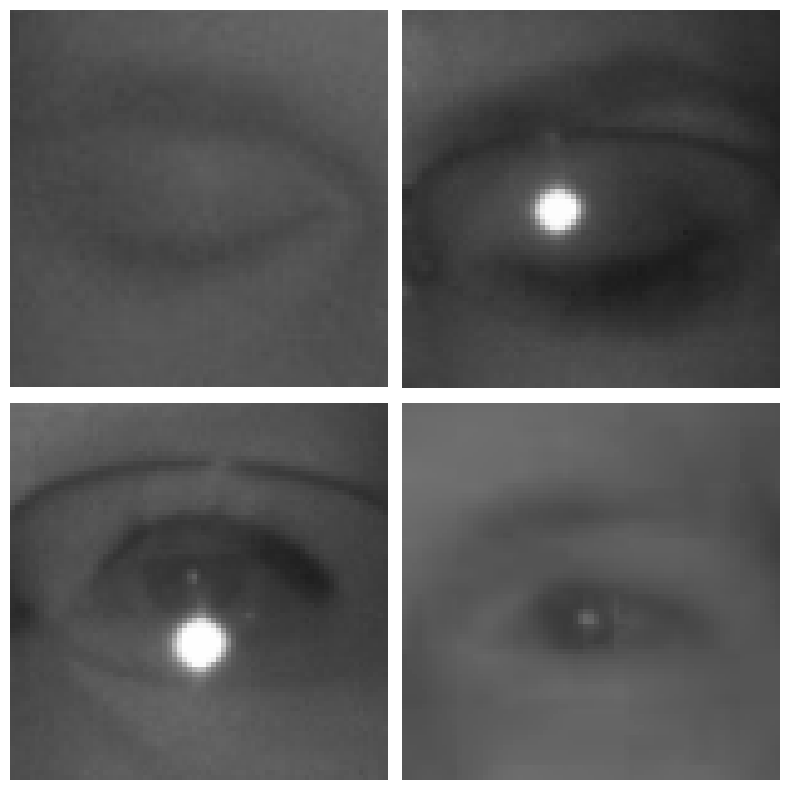

In [13]:
import os
import matplotlib.pyplot as plt
import cv2

# Pfade zu den Beispielbildern
path_open = "/kaggle/input/mrl-eyes/data/open"  # Verzeichnis für offene Augen
path_closed = "/kaggle/input/mrl-eyes/data/closed"  # Verzeichnis für geschlossene Augen

# Lade jeweils 2 Bilder für offene und geschlossene Augen
open_images = [cv2.imread(os.path.join(path_open, f)) for f in os.listdir(path_open)[:2]]
closed_images = [cv2.imread(os.path.join(path_closed, f)) for f in os.listdir(path_closed)[:2]]

# Konvertiere die Bilder zu RGB (falls nötig)
open_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in open_images]
closed_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in closed_images]

# Erstelle das 2x2-Bildraster
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i, img in enumerate(closed_images + open_images):
    axes[i].imshow(img)
    axes[i].axis('off')
    #axes[i].set_title("Closed" if i < 2 else "Open")

plt.tight_layout()
plt.savefig("mrl_sample_grid.png")  # Speichere das kombinierte Bild
plt.show()

In [121]:
from PIL import Image
import os

image_path = "/kaggle/input/mrl-eyes/data/closed/s0007_00055_0_0_0_0_0_01.png"

with Image.open(image_path) as img:
    # Bildgröße
    width, height = img.size
    print(f"Bildgröße: {width}x{height} Pixel")
    
    # Anzahl der Farbkanäle
    mode = img.mode
    if mode == "RGB":
        channels = 3
    elif mode == "L":
        channels = 1
    elif mode == "RGBA":
        channels = 4
    else:
        channels = f"Unbekanntes Farbmodell: {mode}"
    
    print(f"Anzahl der Farbkanäle: {channels}")

Bildgröße: 81x81 Pixel
Anzahl der Farbkanäle: 1


# Model Setup

#### Berechnen der Input / Output Größen der Layer

- Visit my paper for a visualization of the input and output values in the following CNN

$$\text{output size} = \left[ \frac{m - k + 2p}{s} \right] + 1$$

Input: 1 x 64 x 64

Layer 1:

In [8]:
(64-3+2*1)+1 # Layer 1: 32x64x64

64

In [9]:
(64-2)/2+1 # Layer 2 nach MaxPooling (kernelsize = 2, stride = kernelsize): 32x32x32

32.0

In [8]:
(32-3+2*1)+1 # Layer 3: 64x32x32

32

In [9]:
(32-2)/2+1 # Layer 4 nach 2. MaxPooling: 64x16x16

16.0

In [10]:
64*16*16

16384

Layer 5 flattens the output to a column vector of 16384 x 1

This follows a standard architecture of CNNs:

- repeated blocks of convolution-activation-pooling with increasing number of feature maps, followed by a flatten and then one or more linear layers for classification

Before loading the data with the ImageFolder use the provided image_folder_setup.py in my GitHub repo for a clean folder set up.

# Getting the mean and std

In [147]:
#### ALTE METHODE ####

base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Dataset mit Basis-Transformationen
dataset_full = ImageFolder("/kaggle/input/mrl-eyes/data", transform=base_transforms)

loader = DataLoader(dataset_full, batch_size=64, shuffle=False, num_workers=num_cpus)

print("Berechnung der Mittelwerte und Standardabweichungen...")
mean_sum = 0
std_sum = 0
n_batches = 0

for images, _ in loader:
    mean_sum += images.mean(dim=(0, 2, 3))  # Mittelwert über H, W und Batch-Dimension
    std_sum += images.std(dim=(0, 2, 3))    # Standardabweichung über H, W und Batch-Dimension
    n_batches += 1

mean = mean_sum / n_batches
std = std_sum / n_batches

print(f"Mittelwert: {mean}")
print(f"Standardabweichung: {std}")

Berechnung der Mittelwerte und Standardabweichungen...
Mittelwert: tensor([0.3463])
Standardabweichung: tensor([0.0813])


In [7]:
train_dir = "/kaggle/input/mrl-eyes/data"
classes = ["closed", "open"]

train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.png")))

# Definiere deine Transforms
transform = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((64, 64)),
    T.ToTensor()
])

imgs_list = []
for im_path in train_images:
    np_image = imageio.imread(im_path)
    img_tensor = transform(np_image)  # -> (1, 64, 64)
    imgs_list.append(img_tensor)

imgs = torch.stack(imgs_list)
print("Gesamtshape:", imgs.shape)

mean = imgs.mean(dim=(0, 2, 3))
std  = imgs.std(dim=(0, 2, 3))

del imgs  # Speicher freigeben
print("Mean:", mean)
print("Std: ", std)

Gesamtshape: torch.Size([84898, 1, 64, 64])
Mean: tensor([0.3464])
Std:  tensor([0.1327])


# Augmentations for Training

In [8]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),               # Anpassung der Bildgröße (PIL)
    transforms.RandomHorizontalFlip(p=0.5),      # Horizontales Spiegeln (PIL)
    transforms.RandomRotation(degrees=10),       # Rotation (PIL)
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Helligkeit & Kontrast (PIL) <- macht das Sinn? Gibt 3 Farbkanäle wieder
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Affine Transformationen (PIL)
    #transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Weichzeichner (PIL)
    transforms.ToTensor(),                       # Konvertierung zu Tensor
    transforms.Normalize(mean=mean, std=std),
])

dataset_full = ImageFolder(
"/kaggle/input/mrl-eyes/data",
transform=train_transforms)

classes = dataset_full.classes  # ['closed', 'open']

# Aufteilen des Datensatzes, wenn Ornderstruktur nicht schon aufteilt
train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size

train_dataset, val_dataset = random_split(dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_cpus)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_cpus)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Obtain one batch of data from the train loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Choose how many images to show (e.g., 4 for a 2x2 grid)
num_images_to_show = 4

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i in range(num_images_to_show):
    # Convert the tensor to a NumPy array and transpose for imshow (channels-last)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    
    # Undo normalization if necessary, depending on how your transforms are set up
    # For example, if you used ImageNet means and stds, you might do:
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    img = img * std.numpy() + mean.numpy()
    
    axes[i].imshow(np.clip(img, 0, 1), cmap='gray')  # clip to [0,1] in case of normalization
    axes[i].axis('off')
    
    # Set the title based on the label
    axes[i].set_title('Closed' if labels[i].item() == 0 else 'Open')

plt.tight_layout()
plt.savefig('mrl_augmented_sample.png')
plt.show()

NameError: name 'train_loader' is not defined

In [128]:
image, label = dataset_full[0]

In [20]:
image.shape

torch.Size([1, 64, 64])

In [21]:
image

tensor([[[-0.3882, -0.3804, -0.3647,  ..., -0.7098, -0.7020, -0.7020],
         [-0.3882, -0.3804, -0.3647,  ..., -0.7020, -0.7020, -0.7020],
         [-0.3804, -0.3804, -0.3647,  ..., -0.7020, -0.7020, -0.7098],
         ...,
         [-0.6392, -0.6392, -0.6392,  ..., -0.7255, -0.7412, -0.7412],
         [-0.8588, -0.8588, -0.8667,  ..., -0.8980, -0.8980, -0.9059],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]])

In [22]:
dataset_full.classes

['closed', 'open']

In [23]:
type(dataset_full)

torchvision.datasets.folder.ImageFolder

In [8]:
from collections import Counter

class_counts = Counter(dataset_full.targets)

class_0_count = class_counts[0]
class_1_count = class_counts[1]

balance_ratio = class_0_count / class_1_count

print(f"Klasse 0: {class_0_count} Bilder")
print(f"Klasse 1: {class_1_count} Bilder")
print(f"Balance-Verhältnis: {balance_ratio}") # is a balanced dataset

Klasse 0: 41946 Bilder
Klasse 1: 42952 Bilder
Balance-Verhältnis: 0.9765785062395231


In [11]:
def imshow(img, mean, std, file_name=None, save=False, title=None):
    # Denormalisierung der Bilddaten
    img = img * std + mean  # Denormalisierung (mean=0.5, std=0.5)
    
    # Konvertierung zu NumPy und Transposition der Kanäle
    img = img.squeeze(0).numpy()  # Entfernt den Kanal-Dimension (1, H, W) -> (H, W)
    
    # Sicherstellen, dass die Werte im Bereich [0, 1] liegen
    img = np.clip(img, 0, 1)
    
    plt.imshow(img, cmap='gray')  # Graustufenanzeige
    if title:
        plt.title(title)
    plt.axis('off')
    if file_name:
        plt.savefig(f"{file_name}")
    plt.show()

In [107]:
def imshow_col(img, file_name, save=False, title=None):
    # Denormalisierung der Bilddaten
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Denormalisierung

    # Konvertierung zu NumPy und Transposition der Kanäle
    img = img.numpy().transpose((1, 2, 0))

    # Sicherstellen, dass die Werte im Bereich [0, 1] liegen
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    if save == True:
        plt.savefig(f"{file_name}")

In [34]:
images, labels = next(iter(train_loader))

imshow(images[0], title=classes[labels[0]])

NameError: name 'train_loader' is not defined

In [23]:
# note: Order von Aktivierung und Batchnorm getauscht nun erst Aktiv. dann Batchnorm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(32),                           # Hinzufügen von Batch-Normalisierung
            nn.MaxPool2d(kernel_size=2),                  # default Wert für Pooling stride ist = kernel_size
            nn.Dropout(p=0.25),                           # Hinzufügen von Dropout zur Reduzierung von Overfitting

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25),

            nn.AdaptiveAvgPool2d((1, 1)),                 # Anpassung an variable Eingabegrößen
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 1 * 1, 1),
            # Für binäre Klassifikation mit CrossEntropyLoss keine Aktivierungsfunktion hier
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [25]:
model = Net()
print(model)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ELU(alpha=1.0)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ELU(alpha=1.0)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Adaptive

# Model Training

- mit scheduler trainieren

In [16]:
# Hyperparameter
num_epochs = 100     # Maximale Anzahl von Epochen
learning_rate = 0.001
patience = 10        # Early Stopping Geduld

# Liste der Batch-Größen, die Sie testen möchten
batch_sizes = [256, 1024]

# Durchlaufen der verschiedenen Batch-Größen
for batch_size in batch_sizes:
    print(f'\nTraining mit Batch-Größe {batch_size} startet...')
    # DataLoader erstellen (passen Sie train_dataset und val_dataset an Ihre Daten an)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpus)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell, Verlustfunktion und Optimierer initialisieren
    model = Net()
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stopping Variablen
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Listen zum Speichern der Verluste
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device)  # Labels in Float konvertieren

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validierungsphase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.float().to(device)

                val_outputs = model(val_images).squeeze()
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoche {epoch+1}, Trainingsverlust: {average_train_loss:.4f}, Validierungsverlust: {average_val_loss:.4f}")

        # Überprüfen, ob sich der Validierungsverlust verbessert hat
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"--> Validierungsverlust verbessert sich auf {best_val_loss:.4f}. Modell gespeichert.")
        else:
            epochs_no_improve += 1
            print(f"--> Keine Verbesserung seit {epochs_no_improve} Epoche(n).")

        # Early Stopping Bedingung
        if epochs_no_improve >= patience:
            print("Keine Verbesserung mehr. Early Stopping wird aktiviert.")
            break

    # Laden der besten Modellgewichte
    model.load_state_dict(best_model_wts)

    # Speichern der Verluste in Dateien
    with open(f'train_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(f'val_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(val_losses, f)

    # Speichern der besten Modellgewichte
    torch.save(best_model_wts, f'best_model_weights_batchsize_{batch_size}.pth')

    print(f"Training mit Batch-Größe {batch_size} abgeschlossen und Verluste gespeichert.")

print("Alle Trainingsläufe abgeschlossen.")


Training mit Batch-Größe 256 startet...
Epoche 1, Trainingsverlust: 0.5539, Validierungsverlust: 0.4733
--> Validierungsverlust verbessert sich auf 0.4733. Modell gespeichert.
Epoche 2, Trainingsverlust: 0.2593, Validierungsverlust: 0.3383
--> Validierungsverlust verbessert sich auf 0.3383. Modell gespeichert.
Epoche 3, Trainingsverlust: 0.1648, Validierungsverlust: 0.1695
--> Validierungsverlust verbessert sich auf 0.1695. Modell gespeichert.
Epoche 4, Trainingsverlust: 0.1296, Validierungsverlust: 0.1074
--> Validierungsverlust verbessert sich auf 0.1074. Modell gespeichert.
Epoche 5, Trainingsverlust: 0.1097, Validierungsverlust: 0.1309
--> Keine Verbesserung seit 1 Epoche(n).
Epoche 6, Trainingsverlust: 0.0978, Validierungsverlust: 0.0793
--> Validierungsverlust verbessert sich auf 0.0793. Modell gespeichert.
Epoche 7, Trainingsverlust: 0.0873, Validierungsverlust: 0.0655
--> Validierungsverlust verbessert sich auf 0.0655. Modell gespeichert.
Epoche 8, Trainingsverlust: 0.0790, Va

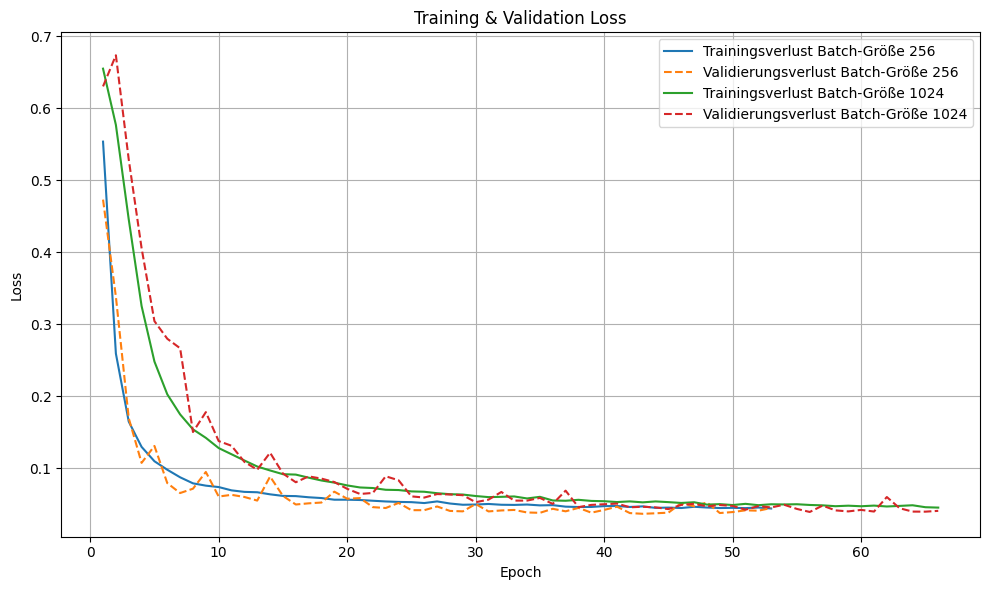

In [2]:
batch_sizes = [256, 1024]

plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    # Laden der Verluste
    with open(f'train_losses_batchsize_{batch_size}.pkl', 'rb') as f:
        train_losses = pickle.load(f)
    with open(f'val_losses_batchsize_{batch_size}.pkl', 'rb') as f:
        val_losses = pickle.load(f)
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plotten der Trainingsverluste
    plt.plot(epochs, train_losses, label=f'Trainingsverlust Batch-Größe {batch_size}')
    
    # Optional: Plotten der Validierungsverluste
    plt.plot(epochs, val_losses, label=f'Validierungsverlust Batch-Größe {batch_size}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.savefig('training_validation_loss.png', dpi=300)
plt.show()

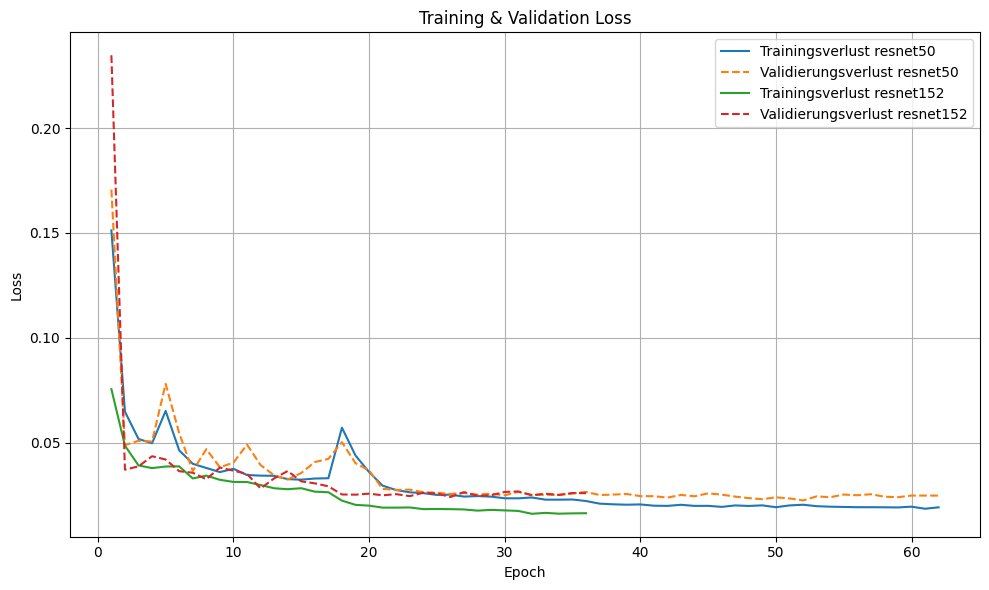

In [3]:
models = {"resnet50": "256", "resnet152": "1024"} #"resnet152": "1024" "resnet50": "256"
plt.figure(figsize=(10, 6))

for key, val in models.items():
    # Laden der Verluste
    with open(f'II_{key}_train_losses_batchsize_{val}.pkl', 'rb') as f:
        train_losses = pickle.load(f)
    with open(f'II_{key}_val_losses_batchsize_{val}.pkl', 'rb') as f:
        val_losses = pickle.load(f)
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plotten der Trainingsverluste
    plt.plot(epochs, train_losses, label=f'Trainingsverlust {key}')
    
    # Optional: Plotten der Validierungsverluste
    plt.plot(epochs, val_losses, label=f'Validierungsverlust {key}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.savefig('training_validation_loss_resnet.png', dpi=300)
plt.show()

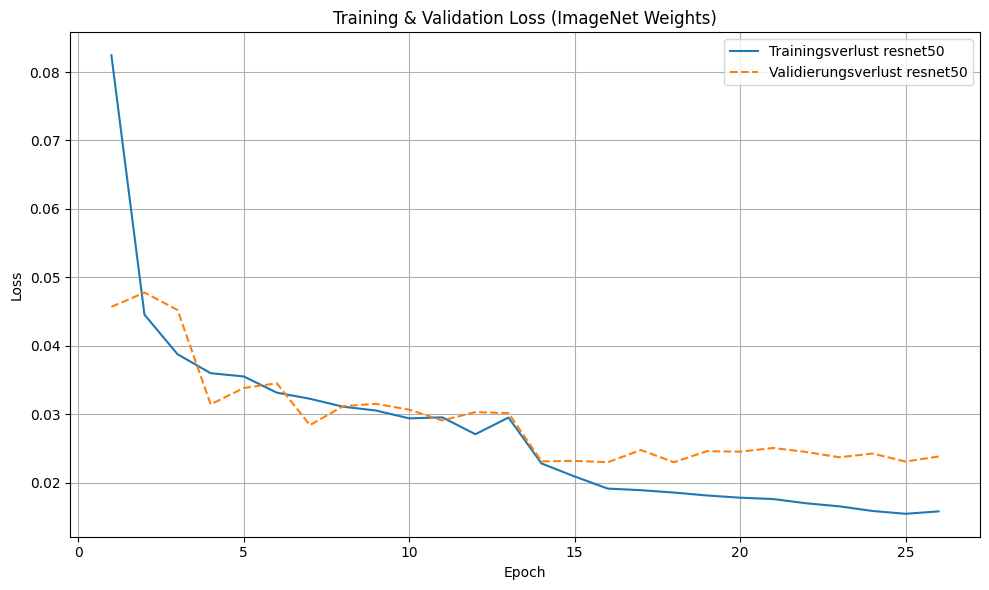

In [1]:
models = {"resnet50": "256"} #"resnet152": "1024" "resnet50": "256"
plt.figure(figsize=(10, 6))

for key, val in models.items():
    # Laden der Verluste
    with open(f'imagenet_{key}_train_losses_batchsize_{val}.pkl', 'rb') as f:
        train_losses = pickle.load(f)
    with open(f'imagenet_{key}_val_losses_batchsize_{val}.pkl', 'rb') as f:
        val_losses = pickle.load(f)
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plotten der Trainingsverluste
    plt.plot(epochs, train_losses, label=f'Trainingsverlust {key}')
    
    # Optional: Plotten der Validierungsverluste
    plt.plot(epochs, val_losses, label=f'Validierungsverlust {key}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (ImageNet Weights)')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.savefig('training_validation_loss_imagenet_resnet.png', dpi=300)
plt.show()

# Model Evaluation


Validierung des Modells mit Batch-Größe 256...


/tmp/ipykernel_30/1921318296.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_weights_batchsize_{batch_size}.pth'))  # Lade

Batch-Größe 256 Ergebnisse:
Präzision: 0.9859
Recall: 0.9889
Accuracy: 0.9872
F1-Score: 0.9874


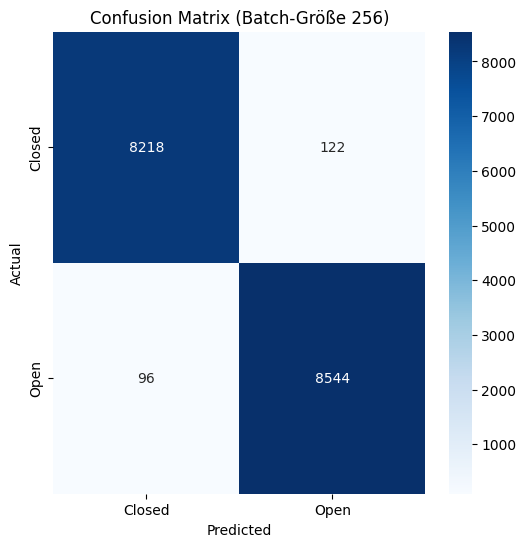


Validierung des Modells mit Batch-Größe 1024...


/tmp/ipykernel_30/1921318296.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_weights_batchsize_{batch_size}.pth'))  # Lade

Batch-Größe 1024 Ergebnisse:
Präzision: 0.9859
Recall: 0.9882
Accuracy: 0.9868
F1-Score: 0.9871


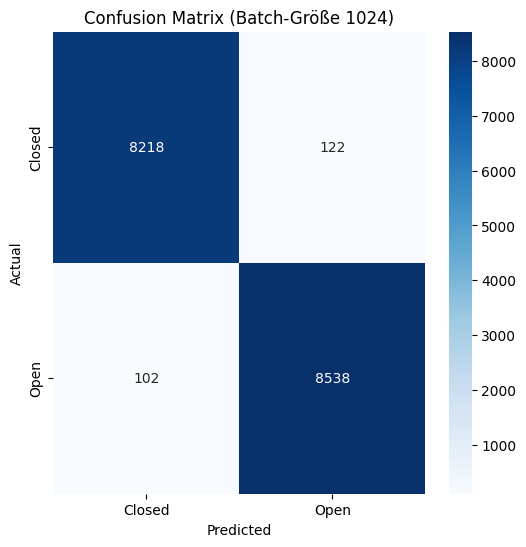

Validierung abgeschlossen.


In [17]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, Accuracy, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der Batch-Größen, die evaluiert werden sollen
batch_sizes = [256, 1024]  # Stellen Sie sicher, dass diese Batch-Größen mit dem Training übereinstimmen

for batch_size in batch_sizes:
    print(f'\nValidierung des Modells mit Batch-Größe {batch_size}...')

    # Validierungs-DataLoader erstellen
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell laden und auf das Gerät übertragen
    model = Net()  # Stellen Sie sicher, dass die Modellarchitektur von `Net` stimmt
    model.load_state_dict(torch.load(f'best_model_weights_batchsize_{batch_size}.pth'))  # Laden der gespeicherten Gewichte
    model.to(device)
    model.eval()

    # Initialisierung der Metriken
    metric_precision = Precision(task="binary").to(device)
    metric_recall = Recall(task="binary").to(device)
    metric_accuracy = Accuracy(task="binary").to(device)
    metric_f1 = F1Score(task="binary").to(device)
    metric_conf_matrix = ConfusionMatrix(task="binary", num_classes=2).to(device)

    all_preds = []
    all_labels = []

    # Validierung
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).long()

            metric_precision.update(preds, labels.long())
            metric_recall.update(preds, labels.long())
            metric_accuracy.update(preds, labels.long())
            metric_f1.update(preds, labels.long())
            metric_conf_matrix.update(preds, labels.long())

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Berechnung der Metriken
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()
    f1_score = metric_f1.compute()
    conf_matrix = metric_conf_matrix.compute()

    print(f"Batch-Größe {batch_size} Ergebnisse:")
    print(f"Präzision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    # Konvertierung der Confusion Matrix zu NumPy für bessere Visualisierung
    conf_matrix = conf_matrix.cpu().numpy()

    # Plotten der Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
    plt.title(f"Confusion Matrix (Batch-Größe {batch_size})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"cnn_conf_matrix_batchsize_{batch_size}.png")
    plt.show()

print("Validierung abgeschlossen.")


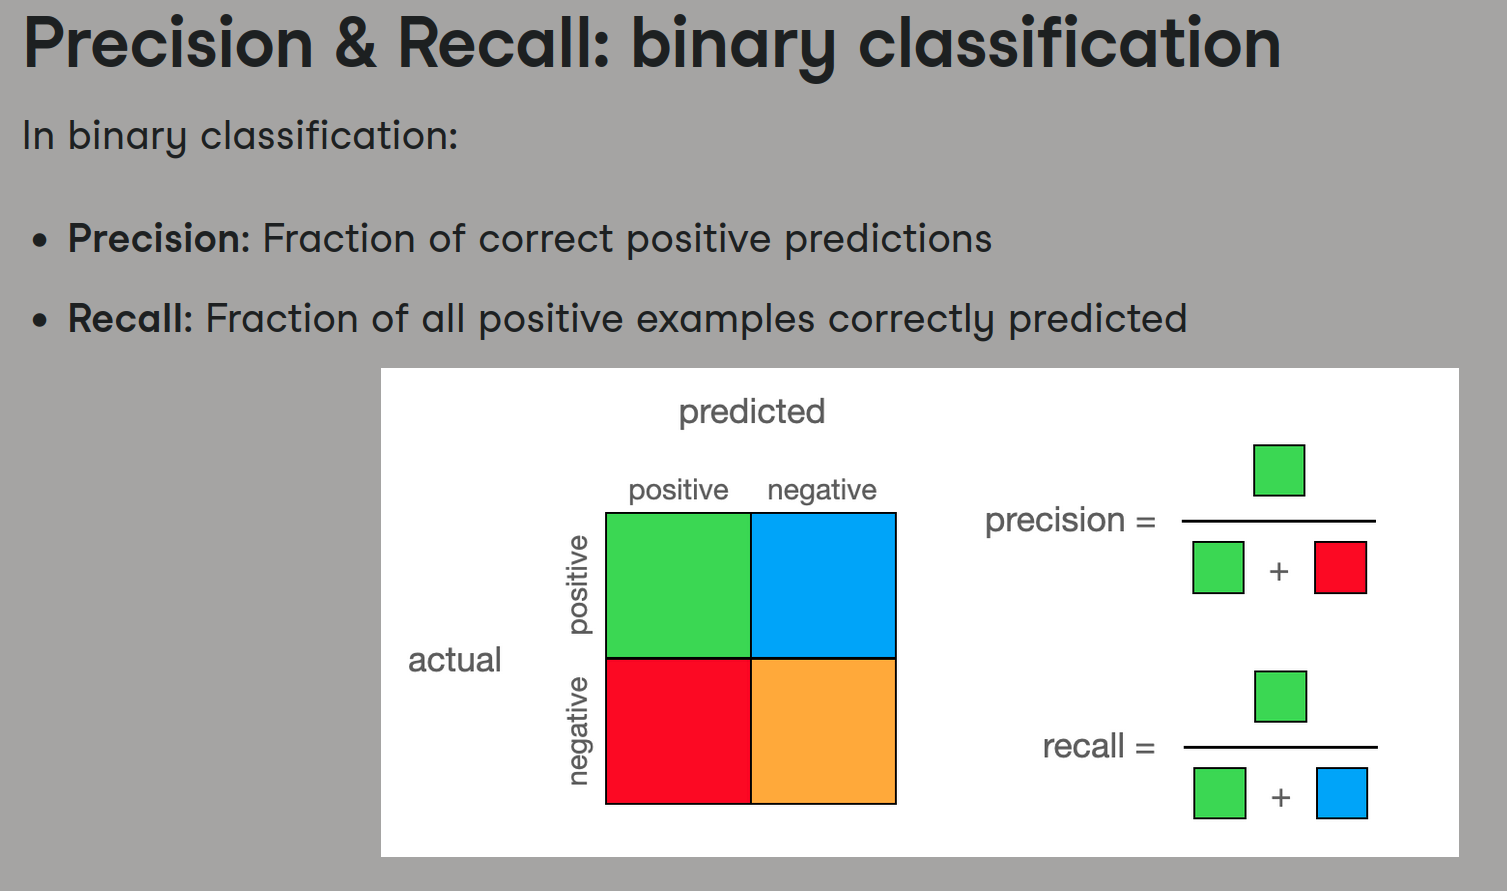

In [27]:
batch_sizes = [128, 256, 1024]
from torchmetrics import Precision, Recall

for batch_size in batch_sizes:
    print(f'\nValidierung des Modells mit Batch-Größe {batch_size}...')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)
    
    model = Net()
    model.load_state_dict(torch.load(f'/kaggle/working/best_model_weights_batchsize_{batch_size}.pth', weights_only=True)) # /kaggle/input/test-model-results/
    model.to(device)
    model.eval()

    # Initialisieren der Metriken
    metric_precision = Precision(task="binary").to(device)
    metric_recall = Recall(task="binary").to(device)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).long()

            metric_precision.update(preds, labels)
            metric_recall.update(preds, labels)

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    print(f"Präzision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")


Validierung des Modells mit Batch-Größe 128...


NameError: name 'Net' is not defined

# ResNets

For performance comparison we train now ResNets

# ResNet

In [188]:
from torchvision.models import ResNet50_Weights

In [189]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [25]:
model = torchvision.models.resnet50()

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

You can see the standard resnet50 takes in in the first convolutional layer 3 input channels and outputs 1000 "class probabilities" in the last fully connected layer. This needs to be adjusted:

In [28]:
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7,
                        stride=2, padding=3, bias=False)
model.fc = nn.Linear(2048, 1)

# Training

In [191]:
# Hyperparameter
num_epochs = 100     # Maximale Anzahl von Epochen
learning_rate = 0.001
patience = 10        # Early Stopping Geduld

# Liste der Batch-Größen, die Sie testen möchten
batch_sizes = [256] # [128, 256, 1024]

# Durchlaufen der verschiedenen Batch-Größen
for batch_size in batch_sizes:
    print(f'\nTraining mit Batch-Größe {batch_size} startet...')
    # DataLoader erstellen (passen Sie train_dataset und val_dataset an Ihre Daten an)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpus)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell, Verlustfunktion und Optimierer initialisieren
    model = model
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=1e-3)

    # Early Stopping Variablen
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Listen zum Speichern der Verluste
    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device)  # Labels in Float konvertieren

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validierungsphase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.float().to(device)

                val_outputs = model(val_images).squeeze()
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

        

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoche {epoch+1}, Trainingsverlust: {average_train_loss:.4f}, Validierungsverlust: {average_val_loss:.4f}")

        
        scheduler.step(average_val_loss)
        current_lr = scheduler.get_last_lr()[0]
        
        if epoch != 0 and current_lr != learning_rates[-1]:
            print(f"Epoche {epoch+1}, Lernrate wurde geändert! Aktuelle Lernrate: {current_lr}")
        learning_rates.append(current_lr)
        
        # Überprüfen, ob sich der Validierungsverlust verbessert hat
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"--> Validierungsverlust verbessert sich auf {best_val_loss:.4f}. Modell gespeichert.")
        else:
            epochs_no_improve += 1
            print(f"--> Keine Verbesserung seit {epochs_no_improve} Epoche(n).")

        # Early Stopping Bedingung
        if epochs_no_improve >= patience:
            print("Keine Verbesserung mehr. Early Stopping wird aktiviert.")
            break

    # Laden der besten Modellgewichte
    model.load_state_dict(best_model_wts)

    # Speichern der Verluste und Learningrates
    with open(f'II_imagenet_resnet50_train_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(f'II_imagenet_resnet50_val_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
    with open(f'II_imagenet_lr_history_{batch_size}.pkl', 'wb') as f:
        pickle.dump(learning_rates, f)

    # Speichern der besten Modellgewichte
    torch.save(best_model_wts, f'II_imagenet_resnet50_best_model_weights_batchsize_{batch_size}.pth')

    print(f"Training mit Batch-Größe {batch_size} abgeschlossen und Verluste gespeichert.")

print("Alle Trainingsläufe abgeschlossen.")


Training mit Batch-Größe 256 startet...
Epoche 1, Trainingsverlust: 0.0716, Validierungsverlust: 0.0721
--> Validierungsverlust verbessert sich auf 0.0721. Modell gespeichert.
Epoche 2, Trainingsverlust: 0.0392, Validierungsverlust: 0.0368
--> Validierungsverlust verbessert sich auf 0.0368. Modell gespeichert.
Epoche 3, Trainingsverlust: 0.0345, Validierungsverlust: 0.0391
--> Keine Verbesserung seit 1 Epoche(n).
Epoche 4, Trainingsverlust: 0.0339, Validierungsverlust: 0.0354
--> Validierungsverlust verbessert sich auf 0.0354. Modell gespeichert.
Epoche 5, Trainingsverlust: 0.0321, Validierungsverlust: 0.0446
--> Keine Verbesserung seit 1 Epoche(n).
Epoche 6, Trainingsverlust: 0.0318, Validierungsverlust: 0.0322
--> Validierungsverlust verbessert sich auf 0.0322. Modell gespeichert.
Epoche 7, Trainingsverlust: 0.0291, Validierungsverlust: 0.0313
--> Validierungsverlust verbessert sich auf 0.0313. Modell gespeichert.
Epoche 8, Trainingsverlust: 0.0292, Validierungsverlust: 0.0386
--> K

# Evaluation


Validierung des Modells mit Batch-Größe 256...
Batch-Größe 256 Ergebnisse:
Präzision: 0.9906
Recall: 0.9946
Accuracy: 0.9924
F1-Score: 0.9926


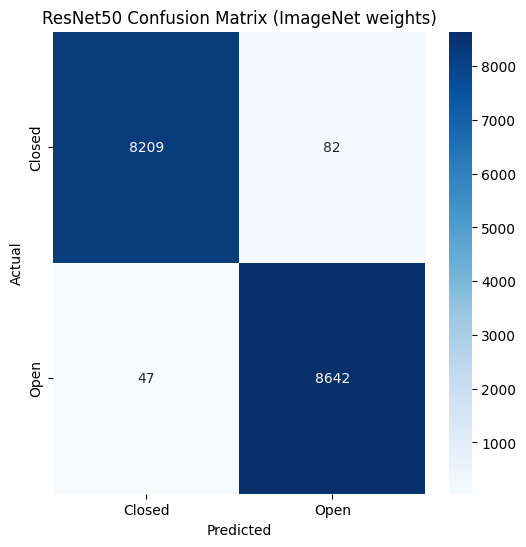

In [25]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, Accuracy, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

batch_sizes = [256] # [128, 256, 1024]

for batch_size in batch_sizes:
    print(f'\nValidierung des Modells mit Batch-Größe {batch_size}...')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell laden und auf das Gerät übertragen
    model = model
    model.load_state_dict(torch.load(f'imagenet_resnet50_best_model_weights_batchsize_{batch_size}.pth', weights_only=True))
    model.to(device)
    model.eval()

    # Initialisierung der Metriken
    metric_precision = Precision(task="binary").to(device)
    metric_recall = Recall(task="binary").to(device)
    metric_accuracy = Accuracy(task="binary").to(device)
    metric_f1 = F1Score(task="binary").to(device)
    metric_conf_matrix = ConfusionMatrix(task="binary", num_classes=2).to(device)

    all_preds = []
    all_labels = []

    # Validierung
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).long()

            metric_precision.update(preds, labels)
            metric_recall.update(preds, labels)
            metric_accuracy.update(preds, labels)
            metric_f1.update(preds, labels)
            metric_conf_matrix.update(preds, labels)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Berechnung der Metriken
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()
    f1_score = metric_f1.compute()
    conf_matrix = metric_conf_matrix.compute()

    print(f"Batch-Größe {batch_size} Ergebnisse:")
    print(f"Präzision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    
    # Konvertierung der Confusion Matrix zu NumPy für bessere Visualisierung
    conf_matrix = conf_matrix.cpu().numpy()

    # Plotten der Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
    plt.title(f"ResNet50 Confusion Matrix (ImageNet weights)") # (ImageNet weights) (Batch-Größe {batch_size})
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"imagenet_cm_resnet50_{batch_size}")
    plt.show()

In [18]:
model = torchvision.models.resnet152()

In [26]:
from torchvision.models import ResNet152_Weights
model = torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 92.3MB/s] 


In [30]:
#print(model)

In [19]:
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7,
                        stride=2, padding=3, bias=False)
model.fc = nn.Linear(2048, 1)

In [29]:
# Hyperparameter
num_epochs = 100     # Maximale Anzahl von Epochen
learning_rate = 0.001
patience = 10        # Early Stopping Geduld

# Liste der Batch-Größen, die Sie testen möchten
batch_sizes = [1024] # [128, 256, 1024]

# Durchlaufen der verschiedenen Batch-Größen
for batch_size in batch_sizes:
    print(f'\nTraining mit Batch-Größe {batch_size} startet...')
    # DataLoader erstellen (passen Sie train_dataset und val_dataset an Ihre Daten an)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpus)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell, Verlustfunktion und Optimierer initialisieren
    model = model
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=1e-3)

    # Early Stopping Variablen
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Listen zum Speichern der Verluste
    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device)  # Labels in Float konvertieren

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validierungsphase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.float().to(device)

                val_outputs = model(val_images).squeeze()
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

        

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f"Epoche {epoch+1}, Trainingsverlust: {average_train_loss:.4f}, Validierungsverlust: {average_val_loss:.4f}")

        
        scheduler.step(average_val_loss)
        current_lr = scheduler.get_last_lr()[0]
        
        if epoch != 0 and current_lr != learning_rates[-1]:
            print(f"Epoche {epoch+1}, Lernrate wurde geändert! Aktuelle Lernrate: {current_lr}")
        learning_rates.append(current_lr)
        
        # Überprüfen, ob sich der Validierungsverlust verbessert hat
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"--> Validierungsverlust verbessert sich auf {best_val_loss:.4f}. Modell gespeichert.")
        else:
            epochs_no_improve += 1
            print(f"--> Keine Verbesserung seit {epochs_no_improve} Epoche(n).")

        # Early Stopping Bedingung
        if epochs_no_improve >= patience:
            print("Keine Verbesserung mehr. Early Stopping wird aktiviert.")
            break

    # Laden der besten Modellgewichte
    model.load_state_dict(best_model_wts)

    # Speichern der Verluste und Learningrates
    with open(f'imagenet_resnet152_train_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(f'imagenet_resnet152_val_losses_batchsize_{batch_size}.pkl', 'wb') as f:
        pickle.dump(val_losses, f)
        
    with open(f'imagenet_resnet152_lr_history_{batch_size}.pkl', 'wb') as f:
        pickle.dump(learning_rates, f)

    # Speichern der besten Modellgewichte
    torch.save(best_model_wts, f'imagenet_resnet152_best_model_weights_batchsize_{batch_size}.pth')

    print(f"Training mit Batch-Größe {batch_size} abgeschlossen und Verluste gespeichert.")

print("Alle Trainingsläufe abgeschlossen.")


Training mit Batch-Größe 1024 startet...
Epoche 1, Trainingsverlust: 0.1061, Validierungsverlust: 0.0659
--> Validierungsverlust verbessert sich auf 0.0659. Modell gespeichert.
Epoche 2, Trainingsverlust: 0.0424, Validierungsverlust: 0.0498
--> Validierungsverlust verbessert sich auf 0.0498. Modell gespeichert.
Epoche 3, Trainingsverlust: 0.0358, Validierungsverlust: 0.0326
--> Validierungsverlust verbessert sich auf 0.0326. Modell gespeichert.
Epoche 4, Trainingsverlust: 0.0307, Validierungsverlust: 0.0369
--> Keine Verbesserung seit 1 Epoche(n).
Epoche 5, Trainingsverlust: 0.0296, Validierungsverlust: 0.0353
--> Keine Verbesserung seit 2 Epoche(n).
Epoche 6, Trainingsverlust: 0.0285, Validierungsverlust: 0.0315
--> Validierungsverlust verbessert sich auf 0.0315. Modell gespeichert.
Epoche 7, Trainingsverlust: 0.0268, Validierungsverlust: 0.0345
--> Keine Verbesserung seit 1 Epoche(n).
Epoche 8, Trainingsverlust: 0.0256, Validierungsverlust: 0.0314
--> Validierungsverlust verbessert 


Validierung des Modells mit Batch-Größe 1024...
Batch-Größe 1024 Ergebnisse:
Präzision: 0.9947
Recall: 0.9762
Accuracy: 0.9852
F1-Score: 0.9853


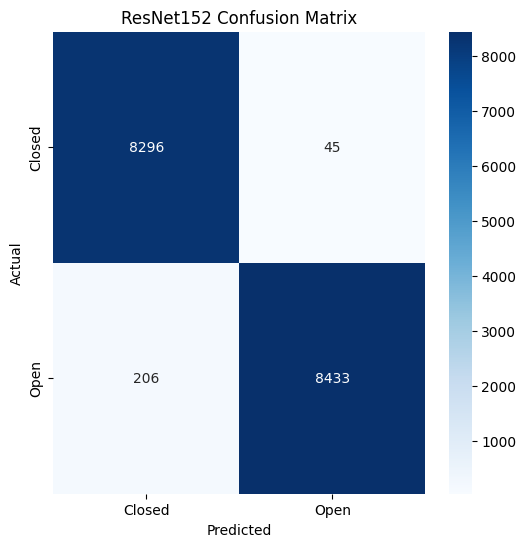

In [86]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, Accuracy, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

batch_sizes = [1024] # [128, 256, 1024]

for batch_size in batch_sizes:
    print(f'\nValidierung des Modells mit Batch-Größe {batch_size}...')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell laden und auf das Gerät übertragen
    model = model
    model.load_state_dict(torch.load(f'resnet152_best_model_weights_batchsize_{batch_size}.pth', weights_only=True))
    model.to(device)
    model.eval()

    # Initialisierung der Metriken
    metric_precision = Precision(task="binary").to(device)
    metric_recall = Recall(task="binary").to(device)
    metric_accuracy = Accuracy(task="binary").to(device)
    metric_f1 = F1Score(task="binary").to(device)
    metric_conf_matrix = ConfusionMatrix(task="binary", num_classes=2).to(device)

    all_preds = []
    all_labels = []

    # Validierung
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).long()

            metric_precision.update(preds, labels)
            metric_recall.update(preds, labels)
            metric_accuracy.update(preds, labels)
            metric_f1.update(preds, labels)
            metric_conf_matrix.update(preds, labels)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Berechnung der Metriken
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()
    f1_score = metric_f1.compute()
    conf_matrix = metric_conf_matrix.compute()

    print(f"Batch-Größe {batch_size} Ergebnisse:")
    print(f"Präzision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    
    # Konvertierung der Confusion Matrix zu NumPy für bessere Visualisierung
    conf_matrix = conf_matrix.cpu().numpy()

    # Plotten der Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
    plt.title(f"ResNet152 Confusion Matrix") #Batch-Größe {batch_size}
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"test_cm_resnet152_{batch_size})")
    plt.show()

# Evaluating on different data set

In [125]:
from PIL import Image
import os

image_path = "/kaggle/input/michalmlodawski-resized/cropped_MichalMlodawski_data/closed/closed_left_0.jpg"

with Image.open(image_path) as img:
    # Bildgröße
    width, height = img.size
    print(f"Bildgröße: {width}x{height} Pixel")
    
    # Anzahl der Farbkanäle
    mode = img.mode
    if mode == "RGB":
        channels = 3
    elif mode == "L":
        channels = 1
    elif mode == "RGBA":
        channels = 4
    else:
        channels = f"Unbekanntes Farbmodell: {mode}"
    
    print(f"Anzahl der Farbkanäle: {channels}")

Bildgröße: 44x14 Pixel
Anzahl der Farbkanäle: 3


In [126]:
ai_data = ImageFolder("/kaggle/input/michalmlodawski-resized/cropped_MichalMlodawski_data", transform=base_transforms)
ai_loader = DataLoader(dataset_full, batch_size=64, shuffle=False, num_workers=num_cpus)

In [127]:
ai_data.classes

['closed', 'open']

In [128]:
class_counts = Counter(ai_data.targets)

class_0_count = class_counts[0]
class_1_count = class_counts[1]

balance_ratio = class_0_count / class_1_count

print(f"Klasse 0: {class_0_count} Bilder")
print(f"Klasse 1: {class_1_count} Bilder")
print(f"Balance-Verhältnis: {balance_ratio}") # Für Testing kein Problem?

Klasse 0: 142410 Bilder
Klasse 1: 110708 Bilder
Balance-Verhältnis: 1.2863569028435162


In [129]:
print("Berechnung der Mittelwerte und Standardabweichungen...")
mean_sum = 0
std_sum = 0
n_batches = 0

for images, _ in ai_loader:
    mean_sum += images.mean(dim=(0, 2, 3))  # Mittelwert über H, W und Batch-Dimension
    std_sum += images.std(dim=(0, 2, 3))    # Standardabweichung über H, W und Batch-Dimension
    n_batches += 1

mean = mean_sum / n_batches
std = std_sum / n_batches

print(f"Mittelwert: {mean}")
print(f"Standardabweichung: {std}")

Berechnung der Mittelwerte und Standardabweichungen...
Mittelwert: tensor([-0.3923])
Standardabweichung: tensor([1.4766])


In [130]:
test_transform = base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [131]:
test_dataset = ImageFolder("/kaggle/input/michalmlodawski-resized/cropped_MichalMlodawski_data", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True, num_workers=num_cpus)

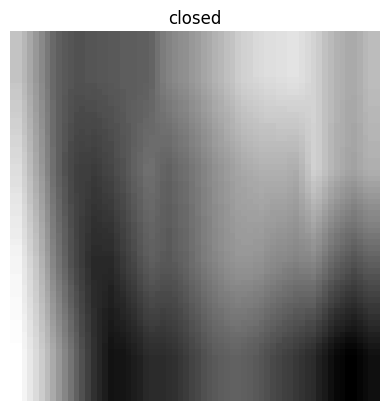

In [140]:
images, labels = next(iter(test_loader))

imshow(images[0], mean=mean, std=std, title=classes[labels[0]])


Validierung des Modells mit Batch-Größe 256...
Batch-Größe 256 Ergebnisse:
Präzision: 0.0000
Recall: 0.0000
Accuracy: 0.5626
F1-Score: 0.0000


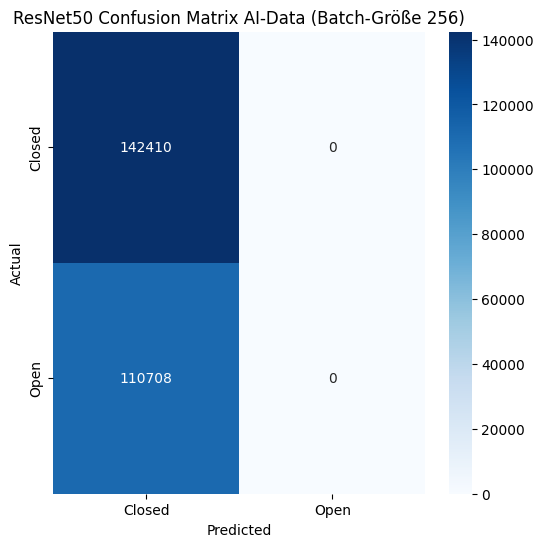


Validierung des Modells mit Batch-Größe 1024...
Batch-Größe 1024 Ergebnisse:
Präzision: 0.0000
Recall: 0.0000
Accuracy: 0.5626
F1-Score: 0.0000


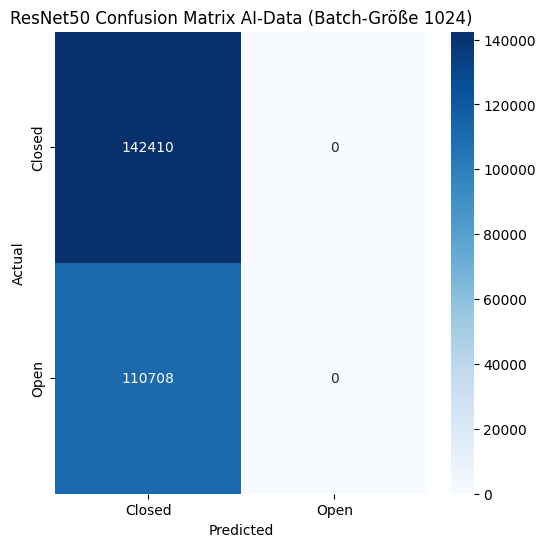

In [133]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, Accuracy, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

#batch_sizes = [128, 256, 1024]

for batch_size in batch_sizes:
    print(f'\nValidierung des Modells mit Batch-Größe {batch_size}...')
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

    # Modell laden und auf das Gerät übertragen
    model = model
    model.load_state_dict(torch.load(f'resnet50_best_model_weights_batchsize_{batch_size}.pth', weights_only=True))
    model.to(device)
    model.eval()

    # Initialisierung der Metriken
    metric_precision = Precision(task="binary").to(device)
    metric_recall = Recall(task="binary").to(device)
    metric_accuracy = Accuracy(task="binary").to(device)
    metric_f1 = F1Score(task="binary").to(device)
    metric_conf_matrix = ConfusionMatrix(task="binary", num_classes=2).to(device)

    all_preds = []
    all_labels = []

    # Validierung
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images).squeeze()
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).long()

            metric_precision.update(preds, labels)
            metric_recall.update(preds, labels)
            metric_accuracy.update(preds, labels)
            metric_f1.update(preds, labels)
            metric_conf_matrix.update(preds, labels)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Berechnung der Metriken
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()
    f1_score = metric_f1.compute()
    conf_matrix = metric_conf_matrix.compute()

    print(f"Batch-Größe {batch_size} Ergebnisse:")
    print(f"Präzision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    
    # Konvertierung der Confusion Matrix zu NumPy für bessere Visualisierung
    conf_matrix = conf_matrix.cpu().numpy()

    # Plotten der Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Closed", "Open"], yticklabels=["Closed", "Open"])
    plt.title(f"ResNet50 Confusion Matrix AI-Data (Batch-Größe {batch_size})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"resnet50_AI-Data_{batch_size})")
    plt.show()


# Evaluating on Experiment Video

In [12]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchmetrics import Precision, Recall, Accuracy, F1Score, ConfusionMatrix
from torchmetrics.classification import MatthewsCorrCoef, AUROC
import torchvision.transforms as T

In [13]:
#############################
# 1) Daten laden
#############################
blink_path = r"/kaggle/input/video-experiment/Blink"

labels1 = np.load("/kaggle/input/video-experiment/Blink/henning_closed_eyes_labels.npy")
labels2 = np.load("/kaggle/input/labels2/henning_closed_eyes_labels2.npy")
labels = np.concatenate([labels1, labels2])
left_eye_data = np.load("/kaggle/input/video-experiment/Blink/henning_lefteye.npy")
right_eye_data = np.load("/kaggle/input/video-experiment/Blink/henning_righteye.npy")

left_eye_data = left_eye_data[:20000]
right_eye_data = right_eye_data[:20000]

labels[labels == 2] = 0 # Alle "2" als "0" interpretieren (ruven: 1=closed 0=open) (ich: 1=open 0=closed)

labels = 1 - labels

print("Labels shape:", labels.shape)
print("Left eye data shape:", left_eye_data.shape)
print("Right eye data shape:", right_eye_data.shape)

# Beispielhafter Check: Alle Arrays sollten dieselbe Länge N haben
assert len(labels) == len(left_eye_data) == len(right_eye_data), "Unerwartete Längen!"

Labels shape: (20000,)
Left eye data shape: (20000, 100, 100)
Right eye data shape: (20000, 100, 100)


In [2]:
unique_vals, counts = np.unique(labels, return_counts=True)
print("Label-Verteilung:")
for val, cnt in zip(unique_vals, counts):
    print(f"  Label {val}: {cnt} Einträge")

Label-Verteilung:
  Label 0: 171 Einträge
  Label 1: 19829 Einträge


In [3]:
###############################################################################
# 2) Basis-Transformationen
###############################################################################

base_transforms = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [4]:
###############################################################################
# 3) Custom Dataset (EyeDataset)
###############################################################################
class EyeDataset(Dataset):
    """
    Gibt bei __getitem__ einen Tupel (left_img_tensor, right_img_tensor, label) zurück.
    """
    def __init__(self, left_data, right_data, labels, transform=None):
        assert len(left_data) == len(right_data) == len(labels), \
            "Mismatch in data length between left, right, and labels."
        self.left_data = left_data
        self.right_data = right_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        left_img = self.left_data[idx]   # NumPy-Array (H, W) oder (H, W, 3)
        right_img = self.right_data[idx]
        label = self.labels[idx]

        # Links
        if len(left_img.shape) == 2:
            left_pil = Image.fromarray(left_img.astype(np.uint8), mode='L')
        else:
            left_pil = Image.fromarray(left_img.astype(np.uint8))

        # Rechts
        if len(right_img.shape) == 2:
            right_pil = Image.fromarray(right_img.astype(np.uint8), mode='L')
        else:
            right_pil = Image.fromarray(right_img.astype(np.uint8))

        # Transform anwenden
        if self.transform is not None:
            left_pil = self.transform(left_pil)   # -> Tensor (C, H, W)
            right_pil = self.transform(right_pil)

        return left_pil, right_pil, label


In [25]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class EyeDataset(Dataset):
    """
    Returns a tuple (left_img_tensor, right_img_tensor, label) in __getitem__.
    Handles potential BGR->RGB reordering and correct PIL modes.
    """
    def __init__(self, left_data, right_data, labels, transform=None, bgr_to_rgb=False):
        assert len(left_data) == len(right_data) == len(labels), \
            "Mismatch in data length between left, right, and labels."
        self.left_data = left_data
        self.right_data = right_data
        self.labels = labels
        self.transform = transform
        self.bgr_to_rgb = bgr_to_rgb  # Whether to convert from BGR to RGB

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        left_img = self.left_data[idx]   # NumPy array, could be (H, W) or (H, W, 3)
        right_img = self.right_data[idx]
        label = self.labels[idx]

        # --- Optional BGR->RGB channel swap ---
        # If your images were originally loaded with OpenCV (BGR) and you need RGB,
        # set bgr_to_rgb=True when creating the dataset.
        if self.bgr_to_rgb and left_img.ndim == 3 and left_img.shape[-1] == 3:
            left_img = left_img[..., ::-1]  # swap channels
        if self.bgr_to_rgb and right_img.ndim == 3 and right_img.shape[-1] == 3:
            right_img = right_img[..., ::-1]

        # --- Convert NumPy arrays to PIL Images ---
        # If the image is single-channel, use mode='L' (8-bit grayscale).
        # If the image has three channels, use mode='RGB'.
        if left_img.ndim == 2:
            left_pil = Image.fromarray(left_img.astype(np.uint8), mode='L')
        else:
            left_pil = Image.fromarray(left_img.astype(np.uint8), mode='RGB')

        if right_img.ndim == 2:
            right_pil = Image.fromarray(right_img.astype(np.uint8), mode='L')
        else:
            right_pil = Image.fromarray(right_img.astype(np.uint8), mode='RGB')

        # --- Apply Transforms ---
        if self.transform is not None:
            left_pil = self.transform(left_pil)   # -> Tensor (C, H, W)
            right_pil = self.transform(right_pil)

        return left_pil, right_pil, label


In [5]:
###############################################################################
# 4) DataLoader erstellen
###############################################################################
eye_dataset = EyeDataset(
    left_data=left_eye_data,
    right_data=right_eye_data,
    labels=labels,
    transform=base_transforms
)

eye_loader = DataLoader(
    eye_dataset,
    batch_size=256,     # Passe nach Belieben an (z. B. 64, 128, 256, etc.)
    shuffle=False,      # Validation: meist False
    num_workers=num_cpus       # Passe an deine Umgebung an
)

print("Dataset length:", len(eye_dataset))

Dataset length: 20000


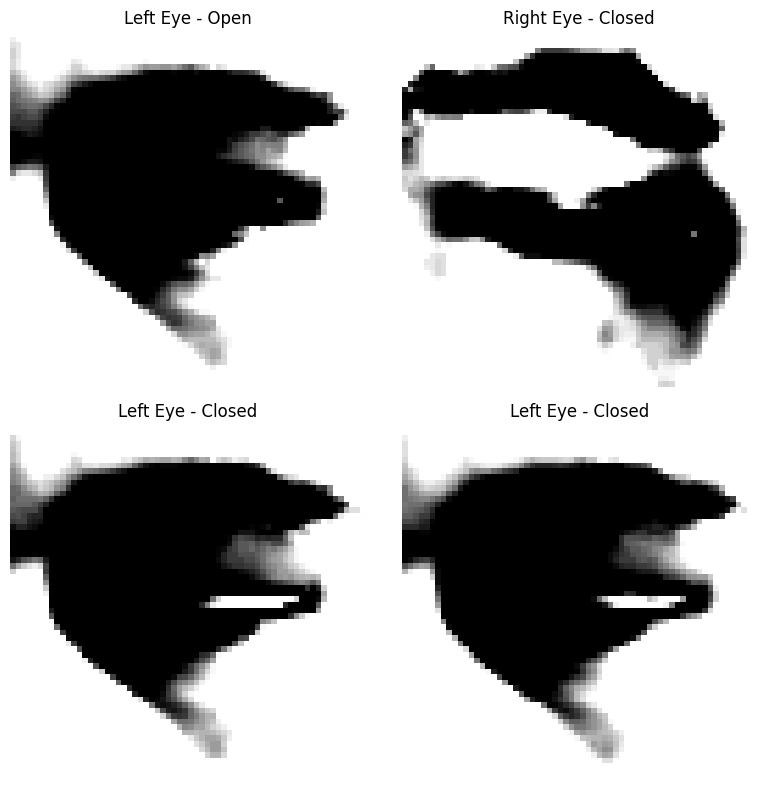

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Obtain one batch of data from the eye data loader
data_iter = iter(eye_loader)
left, right, labels = next(data_iter)

# Choose how many images to show (e.g., 4 for a 2x2 grid)
num_images_to_show = 4

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i in range(num_images_to_show):
    # Randomly select either left or right eye
    if np.random.rand() < 0.5:
        img = left[i]
        eye_side = 'Left'
    else:
        img = right[i]
        eye_side = 'Right'
    
    # Convert the tensor to a NumPy array and transpose for imshow (channels-last)
    img = img.permute(1, 2, 0).cpu().numpy()
    
    # Undo normalization if necessary
    #img = img * std.numpy() + mean.numpy()
    
    axes[i].imshow(np.clip(img, 0, 1), cmap='gray')  # Ensure pixel values are in [0, 1] , cmap='gray'
    axes[i].axis('off')
    
    # Set the title based on the eye side and label (0: Closed, 1: Open)
    label_text = 'Closed' if labels[i].item() == 0 else 'Open'
    axes[i].set_title(f'{eye_side} Eye - {label_text}')

plt.tight_layout()
plt.savefig('experimentg_grid_sample.png')
plt.show()

In [29]:
%%capture
###############################################################################
# 5) Modell laden/vorbereiten
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model
model.name = "ResNet50_imagenet"
model.load_state_dict(torch.load("imagenet_resnet50_best_model_weights_batchsize_256.pth",
                                 map_location=device))
model.to(device)
model.eval()

In [30]:
###############################################################################
# 6) TorchMetrics initialisieren
###############################################################################
metric_precision = Precision(task="binary").to(device)
metric_recall = Recall(task="binary").to(device)
metric_accuracy = Accuracy(task="binary").to(device)
metric_f1 = F1Score(task="binary").to(device)
metric_conf_matrix = ConfusionMatrix(task="binary", num_classes=2).to(device)
metric_mcc = MatthewsCorrCoef(task="binary").to(device)
metric_auroc = AUROC(task="binary").to(device)

In [31]:
###############################################################################
# 7) DataFrame zum Speichern der Ergebnisse
###############################################################################
results_table = pd.DataFrame(columns=['ID', 'Eye', 'Label', 'Prediction', 'Probability'])

In [32]:
###############################################################################
# 8) Inference-Loop (Validation)
###############################################################################
global_idx = 0  # Zum Nachvollziehen pro Sample

with torch.no_grad():
    for batch_idx, (left_imgs, right_imgs, labels_batch) in enumerate(
        tqdm(eye_loader, desc="Validation", total=len(eye_loader))
    ):
        left_imgs = left_imgs.to(device)      # (batch_size, 1, 64, 64) falls Graustufen
        right_imgs = right_imgs.to(device)
        labels_batch = labels_batch.to(device)

        # A) Linkes Auge
        logits_left = model(left_imgs).squeeze()   # -> (batch_size,)
        probs_left = torch.sigmoid(logits_left)
        preds_left = (probs_left > 0.5).long()      # 0 oder 1

        # B) Rechtes Auge
        logits_right = model(right_imgs).squeeze()
        probs_right = torch.sigmoid(logits_right)
        preds_right = (probs_right > 0.5).long()

        # Schleife über den Batch
        for i in range(len(labels_batch)):
            true_label = labels_batch[i]
            left_pred = preds_left[i]
            right_pred = preds_right[i]

            # Linkes Auge in die Metriken
            metric_precision.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_recall.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_accuracy.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_f1.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_conf_matrix.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_auroc.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_mcc.update(left_pred.unsqueeze(0), true_label.unsqueeze(0))

            # Ins DataFrame (Left)
            results_table.loc[len(results_table)] = {
                'ID': global_idx,
                'Eye': 'left',
                'Label': int(true_label.item()),
                'Prediction': int(left_pred.item()),
                'Probability': float(probs_left[i].item())
            }

            # Rechtes Auge
            metric_precision.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_recall.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_accuracy.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_f1.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_conf_matrix.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_auroc.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            metric_mcc.update(right_pred.unsqueeze(0), true_label.unsqueeze(0))
            

            # Ins DataFrame (Right)
            results_table.loc[len(results_table)] = {
                'ID': global_idx,
                'Eye': 'right',
                'Label': int(true_label.item()),
                'Prediction': int(right_pred.item()),
                'Probability': float(probs_right[i].item())
            }
            global_idx += 1

Validation: 100%|██████████| 79/79 [03:20<00:00,  2.54s/it]



=== Ergebnisse der Gesamtauswertung ===
Accuracy:   0.9920
Precision:  0.9936
Recall:     0.9983
F1-Score:   0.9960
MatCorCoef: 0.3769
AUROC:      0.6264

Confusion Matrix:
[[   87   255]
 [   66 39592]]


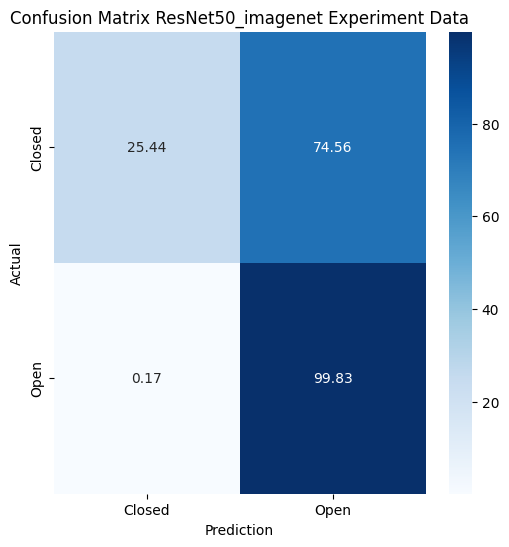

In [33]:
###############################################################################
# 9) Finale Metriken berechnen & ausgeben
###############################################################################
precision_val = metric_precision.compute().item()
recall_val = metric_recall.compute().item()
accuracy_val = metric_accuracy.compute().item()
f1_val = metric_f1.compute().item()
metric_auroc_val = metric_auroc.compute().item()
metric_mcc_val = metric_mcc.compute().item()
conf_matrix = metric_conf_matrix.compute().cpu().numpy()


print("\n=== Ergebnisse der Gesamtauswertung ===")
print(f"Accuracy:   {accuracy_val:.4f}")
print(f"Precision:  {precision_val:.4f}")
print(f"Recall:     {recall_val:.4f}")
print(f"F1-Score:   {f1_val:.4f}")
print(f"MatCorCoef: {metric_mcc_val:.4f}")
print(f"AUROC:      {metric_auroc_val:.4f}\n")

print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f", 
    cmap="Blues",
    xticklabels=["Closed", "Open"],
    yticklabels=["Closed", "Open"]
)
plt.title(f"Confusion Matrix {model.name} Experiment Data")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.savefig(f"1503_cm_{model.name}")
plt.show()

In [19]:
print("\nSample of results_table:")
print(results_table.head(10))


Sample of results_table:
   ID    Eye  Label  Prediction  Probability
0   0   left      1           1     0.995454
1   0  right      1           1     0.995353
2   1   left      0           0     0.464313
3   1  right      0           0     0.040280
4   2   left      0           0     0.027213
5   2  right      0           0     0.017297
6   3   left      0           0     0.041555
7   3  right      0           0     0.015607
8   4   left      1           1     0.938460
9   4  right      1           0     0.195729


In [20]:
results_table.to_csv("results20k.csv", index=False)

In [21]:
duplicates = results_table.duplicated(subset=["ID", "Eye"]).any()

if duplicates:
    print("Es gibt Duplikate in ['ID', 'Auge']!")
else:
    print("Keine Duplikate in ['ID', 'Auge'].")

Keine Duplikate in ['ID', 'Auge'].


In [23]:
# Pivot-Tabelle erstellen, um "Left" und "Right" nebeneinander zu vergleichen
pivot_table = results_table.pivot(index="ID", columns="Eye", values="Prediction")

# Finde IDs, bei denen die Predictions für "Left" und "Right" unterschiedlich sind
mismatched_ids = pivot_table[pivot_table["left"] != pivot_table["right"]].index

# Filtere die Original-Tabelle basierend auf diesen IDs
mismatched_pairs = results_table[results_table["ID"].isin(mismatched_ids)]

# Ergebnisse anzeigen
print(mismatched_pairs)

          ID    Eye  Label  Prediction  Probability
8          4   left      1           1     0.938460
9          4  right      1           0     0.195729
296      148   left      0           1     0.654852
297      148  right      0           0     0.040522
298      149   left      0           1     0.856498
...      ...    ...    ...         ...          ...
38063  19031  right      1           1     0.690386
39558  19779   left      1           1     0.766276
39559  19779  right      1           0     0.219579
39562  19781   left      1           1     0.768261
39563  19781  right      1           0     0.072221

[434 rows x 5 columns]


In [24]:
mismatched_pairs.to_csv("mismatched_pairs20k.csv", index=False)

In [1]:
results_table[results_table['ID']==4].index[0]

8

In [98]:
results_table.iloc[[297]].index[0]

297

In [13]:
results_table[(results_table['ID'] == selected_id) & (results_table['Eye'] == 'left')]

,ID,Eye,Label,Prediction,Probability
8,4,left,1,1,0.93846


In [6]:
results_table[(results_table['ID'] == 4) & (results_table['Eye'] == 'right')].index[0]

9

In [25]:
len(mismatched_pairs)/len(results_table)*100

1.085

In [134]:
results_table[(results_table['ID'] == 4) & (results_table['Eye'] == 'left')].index[0]

8

In [5]:
left_eye_data[4].shape

(100, 100)

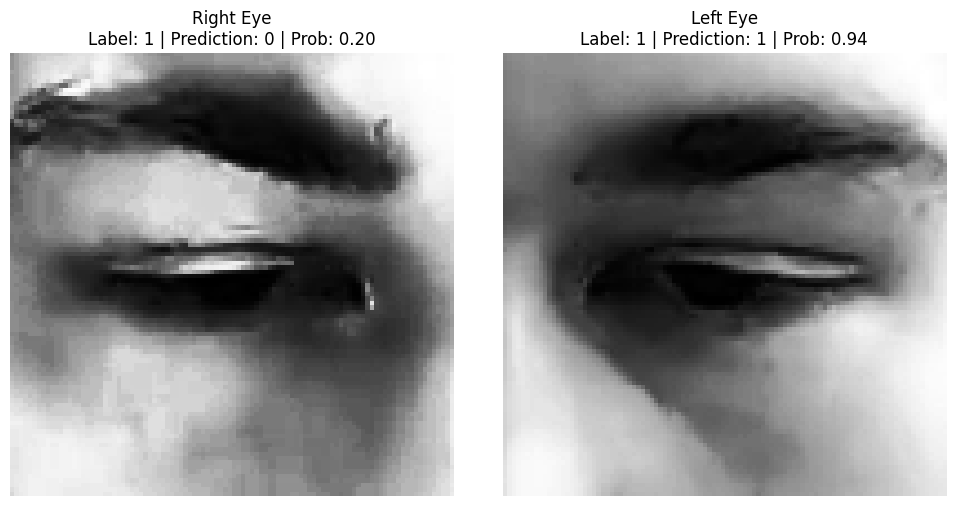

In [6]:
selected_id = 4

# Extrahiere Bilder und Label aus dem Dataset basierend auf der ID
left_img, right_img, label = left_eye_data[selected_id], right_eye_data[selected_id], labels[selected_id] # eye_dataset[selected_id]  # Nutzt ID direkt als Index

# Werte aus results_table für zusätzliche Informationen
left_row = results_table[(results_table['ID'] == selected_id) & (results_table['Eye'] == 'left')].iloc[0]
right_row = results_table[(results_table['ID'] == selected_id) & (results_table['Eye'] == 'right')].iloc[0]

# Bilder plotten
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Linkes Auge
axes[1].imshow(left_img, cmap="gray")
axes[1].set_title(
    f"Left Eye\nLabel: {left_row['Label']} | Prediction: {left_row['Prediction']} | Prob: {left_row['Probability']:.2f}"
)
axes[1].axis("off")

# Rechtes Auge
axes[0].imshow(right_img, cmap="gray")
axes[0].set_title(
    f"Right Eye\nLabel: {right_row['Label']} | Prediction: {right_row['Prediction']} | Prob: {right_row['Probability']:.2f}"
)
axes[0].axis("off")

plt.tight_layout()
plt.show()


In [116]:
next(iter(eye_loader))

[tensor([[[[ 1.0544,  1.1430,  1.2613,  ...,  4.8376,  4.7785,  4.7490],
           [ 0.9361,  1.0544,  1.1726,  ...,  4.8081,  4.7785,  4.7490],
           [ 0.8770,  0.9066,  1.0839,  ...,  4.8376,  4.8081,  4.7490],
           ...,
           [ 3.8032,  4.3352,  4.6012,  ...,  4.1283,  4.1874,  4.2465],
           [ 3.8327,  4.3352,  4.5716,  ...,  4.0396,  4.0987,  4.1874],
           [ 3.8327,  4.3352,  4.5716,  ...,  4.0101,  4.0692,  4.1283]]],
 
 
         [[[ 1.1135,  1.1430,  1.2021,  ...,  4.8672,  4.8672,  4.8376],
           [ 0.9952,  1.0839,  1.1430,  ...,  4.8968,  4.8672,  4.8081],
           [ 0.8770,  0.9361,  1.0544,  ...,  4.8968,  4.8672,  4.8081],
           ...,
           [ 3.4189,  3.8623,  4.3647,  ...,  4.0396,  4.1874,  4.2465],
           [ 3.3894,  3.8327,  4.3352,  ...,  4.0396,  4.1578,  4.2170],
           [ 3.3894,  3.8327,  4.3352,  ...,  4.0396,  4.0987,  4.1874]]],
 
 
         [[[ 1.0839,  1.1430,  1.2908,  ...,  4.8376,  4.8081,  4.7785],
       

In [13]:
eye_dataset[0][2]

1

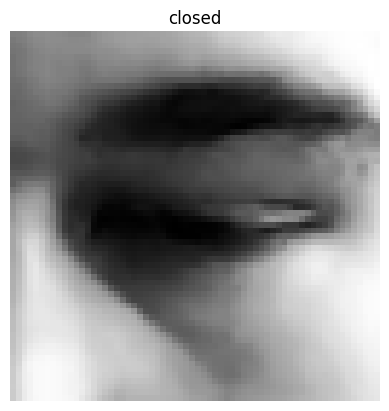

In [18]:
left, right, labels = next(iter(eye_loader))

imshow(left[1], mean=mean, std=std, title=classes[labels[1]])

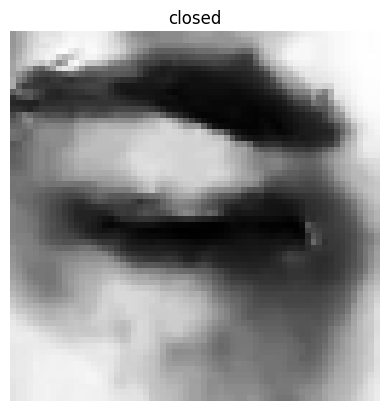

In [19]:
left, right, labels = next(iter(eye_loader))

imshow(right[1], mean=mean, std=std, title=classes[labels[1]])

# -----TRENNER ALTER CODE --------